In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load model
model = load_model(r'C:\Users\atchaya\Downloads\densenet201_transfer.hdf5')

# Create test generator (same as during training)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'dataset/Freshwater Fish Disease Aquaculture in south asia/Test',       # path to your test dataset
    target_size=(224, 224),    # input size for DenseNet201
    batch_size=32,
    class_mode='categorical',  # or 'binary' if 2 classes
    shuffle=False
)

# Evaluate
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")


Found 697 images belonging to 7 classes.

20/22 [==========================>...] - ETA: 7s - loss: 0.2128 - accuracy: 0.9703  




Found 349 validated image filenames belonging to 7 classes.


C:\Users\atchaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


11/11 [==============================] - 50s 4s/step
✅ Classification Report:

                                   precision    recall  f1-score   support

            Bacterial Red disease       1.00      0.98      0.99        50
Bacterial diseases - Aeromoniasis       1.00      0.98      0.99        50
           Bacterial gill disease       0.91      1.00      0.95        50
   Fungal diseases Saprolegniasis       1.00      0.96      0.98        50
                     Healthy Fish       1.00      1.00      1.00        50
               Parasitic diseases       0.98      0.98      0.98        50
Viral diseases White tail disease       0.98      0.96      0.97        49

                         accuracy                           0.98       349
                        macro avg       0.98      0.98      0.98       349
                     weighted avg       0.98      0.98      0.98       349



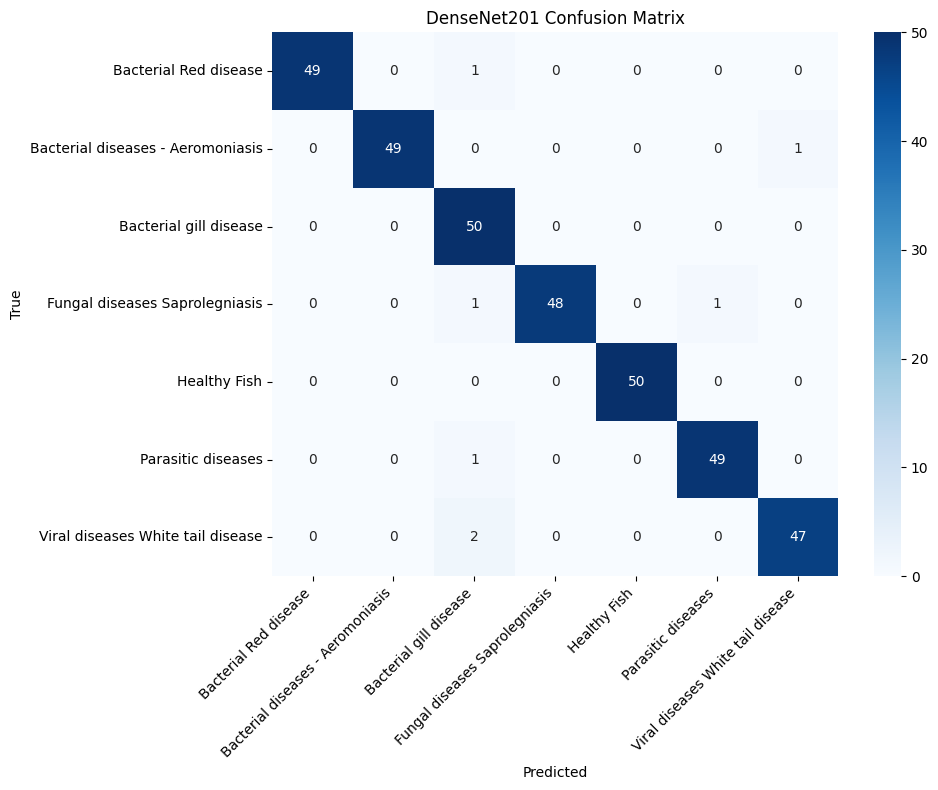

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------
# Load the saved DenseNet201 model
# ----------------------------
model = load_model('densenet201_transfer.hdf5')

# ----------------------------
# Base directory (use your Test folder)
# ----------------------------
eval_dir = 'dataset/Freshwater Fish Disease Aquaculture in south asia/Test'

# ----------------------------
# Classes (match EXACT folder names)
# ----------------------------
classes = [
    'Bacterial Red disease',
    'Bacterial diseases - Aeromoniasis',
    'Bacterial gill disease',
    'Fungal diseases Saprolegniasis',
    'Healthy Fish',
    'Parasitic diseases',
    'Viral diseases White tail disease'
]

# ----------------------------
# Collect 50 images per class
# ----------------------------
filepaths, labels = [], []

for cls in classes:
    class_dir = os.path.join(eval_dir, cls)
    imgs = os.listdir(class_dir)
    
    # Ensure at least 50 images available
    num_samples = min(50, len(imgs))
    chosen = np.random.choice(imgs, num_samples, replace=False)
    
    for img in chosen:
        filepaths.append(os.path.join(class_dir, img))
        labels.append(cls)

# ----------------------------
# Build a DataFrame
# ----------------------------
df = pd.DataFrame({'filename': filepaths, 'class': labels})

# ----------------------------
# ImageDataGenerator (no shuffle)
# ----------------------------
eval_datagen = ImageDataGenerator(rescale=1./255)
eval_generator = eval_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),   # DenseNet201 expects 224x224
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ----------------------------
# Predictions
# ----------------------------
pred_probs = model.predict(eval_generator, steps=len(eval_generator), verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = eval_generator.classes

# ----------------------------
# Confusion Matrix & Classification Report
# ----------------------------
cm = confusion_matrix(true_classes, pred_classes)
print("✅ Classification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=classes))

# ----------------------------
# Plot Confusion Matrix
# ----------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DenseNet201 Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


✅ Temporary evaluation dataset created at: C:\Users\atchaya\AppData\Local\Temp\tmpnowhzkoq
Found 350 images belonging to 7 classes.
11/11 [==============================] - 0s 6ms/step
✅ Classification Report:

                                   precision    recall  f1-score   support

            Bacterial Red disease       0.98      0.98      0.98        50
Bacterial diseases - Aeromoniasis       1.00      1.00      1.00        50
           Bacterial gill disease       1.00      0.98      0.99        50
   Fungal diseases Saprolegniasis       1.00      1.00      1.00        50
                     Healthy Fish       1.00      1.00      1.00        50
               Parasitic diseases       0.98      1.00      0.99        50
Viral diseases White tail disease       1.00      1.00      1.00        50

                         accuracy                           0.99       350
                        macro avg       0.99      0.99      0.99       350
                     weighted avg    

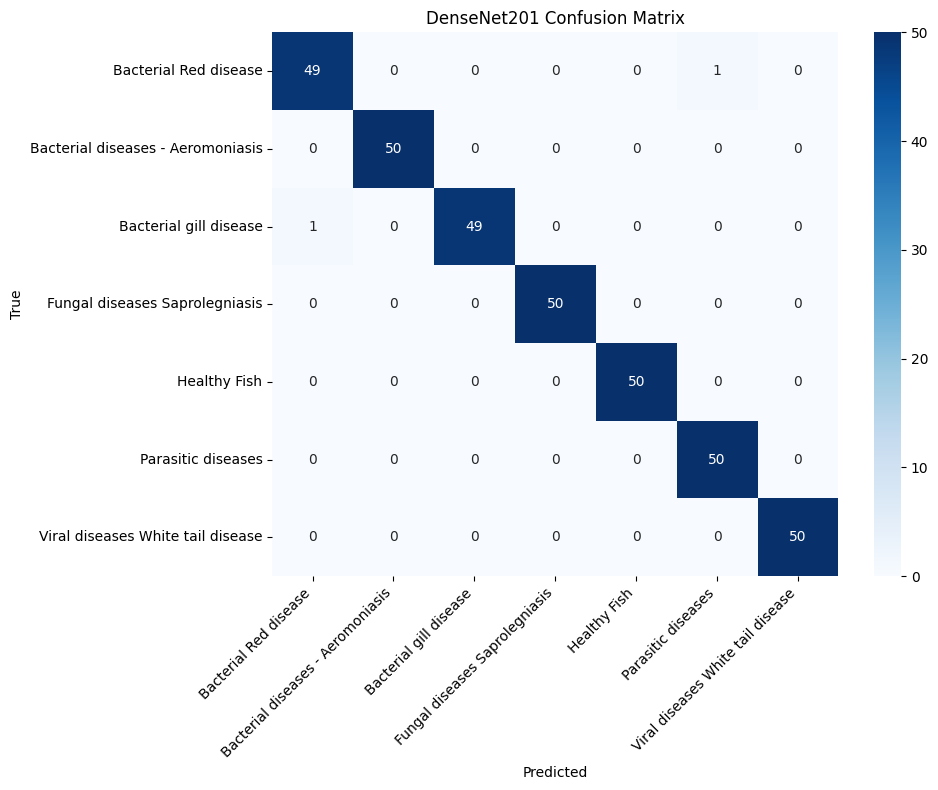

In [3]:
import os
import numpy as np
import random
import shutil
import tempfile
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import DenseNet201
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------
# Load the trained classifier
# (trained on extracted DenseNet201 features)
# ----------------------------
model = load_model("model_2.hdf5")

# ----------------------------
# Same feature extractor used during training
# ----------------------------
conv_base = DenseNet201(weights="imagenet", include_top=False)

# ----------------------------
# Classes (must match folder names exactly)
# ----------------------------
classes = [
    'Bacterial Red disease',
    'Bacterial diseases - Aeromoniasis',
    'Bacterial gill disease',
    'Fungal diseases Saprolegniasis',
    'Healthy Fish',
    'Parasitic diseases',
    'Viral diseases White tail disease'
]

# ----------------------------
# Dataset path
# ----------------------------
eval_dir = "dataset/Freshwater Fish Disease Aquaculture in south asia/Test"

# ----------------------------
# Step 1: Create a temporary folder with 50 random images per class
# ----------------------------
temp_dir = tempfile.mkdtemp()

for cls in classes:
    src_class_dir = os.path.join(eval_dir, cls)
    dst_class_dir = os.path.join(temp_dir, cls)
    os.makedirs(dst_class_dir, exist_ok=True)

    images = [f for f in os.listdir(src_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)
    images = images[:50]  # Select 50 random images

    for img in images:
        shutil.copy(os.path.join(src_class_dir, img), os.path.join(dst_class_dir, img))

print(f"✅ Temporary evaluation dataset created at: {temp_dir}")

# ----------------------------
# Step 2: Prepare Data Generator
# ----------------------------
datagen = ImageDataGenerator(rescale=1./255)

eval_generator = datagen.flow_from_directory(
    temp_dir,
    target_size=(224, 224),   # DenseNet201 expects 224x224
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ----------------------------
# Step 3: Extract features using DenseNet201
# ----------------------------
features = conv_base.predict(eval_generator, steps=len(eval_generator), verbose=1)
labels = eval_generator.classes

# ----------------------------
# Step 4: Predict using trained classifier
# ----------------------------
pred_probs = model.predict(features, verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)

# ----------------------------
# Step 5: Evaluation
# ----------------------------
print("✅ Classification Report:\n")
print(classification_report(labels, pred_classes, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(labels, pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DenseNet201 Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [5]:
from tensorflow.keras.models import load_model

model = load_model("final_fish_caption_model.hdf5")
for i, layer in enumerate(model.inputs):
    print(f"Input {i}: {layer.shape}")


Input 0: (None, 1920)
Input 1: (None, 14)


In [10]:
import os
import numpy as np
from pickle import load
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.densenet import preprocess_input
import random

# ----------------------------
# 1. Load trained model & tokenizer
# ----------------------------
model = load_model('final_fish_caption_model.hdf5')
tokenizer = load(open('tokenizer.pkl', 'rb'))

# Load validation features
val_features_file = 'features_val.pkl'
val_features = load(open(val_features_file, 'rb'))

# Max caption length (used during training)
max_len = 35  # replace with actual max_len used in training
vocab_size = len(tokenizer.word_index) + 1

# ----------------------------
# 2. Load DenseNet201 for feature extraction
# ----------------------------
conv_base = DenseNet201(weights='imagenet', include_top=False, pooling='avg')  # pooling='avg' to match training

# ----------------------------
# 3. Function to generate caption from model
# ----------------------------
def generate_caption(model, tokenizer, photo_feature, seq_length):
    """Generate a caption for an image given DenseNet201 features."""
    in_text = 'startseq'
    for i in range(seq_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=seq_length, padding='post')  # use seq_length
        yhat = model.predict([photo_feature, sequence], verbose=0)
        yhat_idx = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_idx)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text


# ----------------------------
# 4. Evaluate on validation set
# ----------------------------
val_image_ids = list(val_features.keys())
num_examples = min(10, len(val_image_ids))  # number of examples to display
examples = random.sample(val_image_ids, num_examples)

seq_length = 14  # must match model input
for image_id in examples:
    photo_feature = val_features[image_id]  # shape (1, 1920)
    caption = generate_caption(model, tokenizer, photo_feature, seq_length)
    print(f"Image: {image_id}")
    print(f"Predicted Caption: {caption}\n")




Image: Bacterial Red disease (76)
Predicted Caption: startseq the fish has indications of bacterial red disease endseq

Image: Viral diseases White tail disease (91)
Predicted Caption: startseq a fish showing symptoms of viral diseases white tail disease endseq

Image: Bacterial gill disease (103)
Predicted Caption: startseq the fish has indications of bacterial gill disease endseq

Image: Viral diseases White tail disease (44)
Predicted Caption: startseq a fish showing symptoms of viral diseases white tail disease endseq

Image: Bacterial diseases - Aeromoniasis (25)
Predicted Caption: startseq the fish has indications of bacterial diseases aeromoniasis endseq

Image: Bacterial Red disease (75)
Predicted Caption: startseq the fish has indications of bacterial red disease endseq

Image: Viral diseases White tail disease (77)
Predicted Caption: startseq a fish showing symptoms of viral diseases white tail disease endseq

Image: Viral diseases White tail disease (37)
Predicted Caption: s